# Introduction

> The goal of statistical inference is to make **generalizations about the population** when **only a sample is available**.

___

# Selecting a test

Identifying wich test to use starts with two questions:
+ how many categories of population do you have (example: male vs female, three different trial groups)
+ what is the type of the variable to analyze: nominal, measurement or ranked

Note: 
+ Z-tests for mean serve the same purpose as ANOVA
+ Z-tests for proportions serve the same purpose as chi-square tests

Both tests compare a sample to a given population. Formally, the population SD needs to be known, but we can use a t-test with the sample standard deviation if not.

Additional information can be found [here](http://www.biostathandbook.com/).

### T-test & ANOVA

The variable to analyze is **measurement**: you want to compare the **mean** among categories.
+ **T-test** for roughly Gaussian-distributed data; the test statistic follows a **t-distribution**. 
    + only one measurement variable
    + only one or two samples _(note: for one-sample, you will test against a number that needs to be known beforehand)_
    + both one-tail and two-tailed alternate hypothesis are possible
+ **ANOVA** for roughly Gaussian-distributed data; the test statistic follows an **F-distribution**. 
    + one-way ANOVA when only one measurement variable
    + N-ways otherwise
    + The only alternate hypothesis is that the different categories have different means.
+ **non-parametric** tests otherwise _(typically with less assumptions so less statistical power)_

### Chi-Square

The variable to analyze is **nominal**: you want to compare the **frequencies** among categories.
+ **Chi-Square** test; the test statistic follows a **Chi-Square distribution**.
    + One-way when the nominal variable only has one value (ex: repartition of patient discharges per day of the week)
    + Two-way otherwise: test of independance or conformity (ex: comparing proportion among population categories)
    + The only alternate hypothesis is that the different categories have different frequencies.
+ **Fisher's exact test** if the sample size is small

### Kruskal–Wallis

The variable to analyze is **ranked**: you want to compare the **ranks** among categories.
+ **Kruskal–Wallis** test

### Bonferroni Corrections

The chance of capturing rare event increases when testing multiple hypothesis. It means the likelihood of incorrectly rejecting a null hypothesis (false positive) increases. 

The Bonferroni correction rejects the null hypothesis for each $p_{i} \leq \frac {\alpha}{m}$. This ensures the [Family Wise Error Rate](https://en.wikipedia.org/wiki/Family-wise_error_rate) stays below the significance level $\alpha$. More information can be found [here](https://stats.stackexchange.com/questions/153122/bonferroni-correction-for-post-hoc-analysis-in-anova-regression).

It is useful for post-hoc tests after performing one-way ANOVA or Chi-Square tests that reject the null hypothesis. When comparing $N$ multiple groups, we can either do:
+ pairwise tesing. In that case, $m$ will be ${N \choose 2}$.
+ one vs the rest. In that case, $m$ will be $N$.

___

## Z-tests

### Mean Tests

A **mean test** look for a specific value, typically the average of a population parameter. Its null hypothesis states that $\mu = \mu_0$.

+ According to the CLT, the mean of our sample is part of a normal distribution centered around its population mean
+ The null hypothesis states that the sample belongs to the initial population

It means that we can calculate the position of the sample mean in the sampling distribution that follows $H_0$, provided we know the population standard deviation (see formula in code). 

We calculate its p-value based on the alternate hypothesis to draw our conclusions.

In [47]:
# example: test if a website redesign improved load time. H0: old_load >= new_load, alpha = 0.01
# old_load_mean = 3.125, old_load_sd = 0.700
# new_load_mean = 2.875, new_load_sample_size = 40
# the sample mean of new_load_mean under H0 is in the 1.2% percentile, outside of our cutoff area: we fail to reject H0

import numpy as np
from scipy.stats import norm
z_score = (2.875 - 3.125) / (0.700 / np.sqrt(40))
print('p-value: {:.1%} > 1% cutoff'.format(norm.cdf(x=z_score)))

p-value: 1.2% > 1% cutoff


### Proportion tests

A **proportion test** looks for a share of a population that have a specific trait. We assume that the population follows a binomial distribution with a probability $p_0$ of having a given trait, and the sample has a measured probability $\hat{p}$.

It also leverages the CLT, with the following tweaks:
+ proportions are equal to $\hat{p} - p_0$
+ population variance equals $p_0 \times(1 - p_0)$ according to the binomial distribution

In [53]:
# example: test if most customers of a website are teenagers. H0: teen_proportion <= 0.5 
# sample_teen_proportion = 0.58, sample_size = 400
# H0_teen_proportion = 0.5, HO_variance = sample_size * H0_teen_proportion * (1 - H0_teen_proportion)

# the sample_teen_proportion under H0 is in the 99.9% percentile, inside our cutoff area: we reject H0

import numpy as np
from scipy.stats import norm
z_score = (0.58 - 0.5) / (np.sqrt(0.5 * (1 - 0.5)) / np.sqrt(400))
print('p-value: {:.1%} < 5% cutoff'.format(norm.sf(x=z_score))) # right-tail so survival function = 1 - cdf

p-value: 0.1% < 5% cutoff


___

## T-tests

### Assumptions

The CLT and Z-scores assume **we know the population standard deviation**. Using them does not work when:

+ **$\sigma$ is unknown**
+ the sample size **$n$ is small**

We can substitute the normal distribution with the [Student’s t distribution](https://en.wikipedia.org/wiki/Student's_t-distribution) to represent the **sampling distribution** of the sample statistic when:

+ the sample size **is large** (30+ observations), OR
+ the **population** is roughly **normal** (very small samples)

The tails of the Student Distribution are **thicker than normal** to reflect the **additional uncertainty** introduced by using the sample standard deviation. They get closer to the normal distribution as the degrees of freedom increase (ie. when the sample size increases).

_Note: when the sample size is large (30+ observations), the Student Distribution becomes extremely close to the normal distribution._

Notes:
+ If the sample size is very small, we can use normal probability plots to check whether the sample may come from a normal distribution.
+ If the t-distribution cannot be used, we can use more robust procedures like the one-sample [**Wilcoxon procedure**](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test).

### T-statistic

A t-statistic will be larger (i.e. less likely to happen by chance) if:
+ the compared statistic values are very different 
+ the pooled standard deviation is small, ie. the compared distributions do not overlap much
+ the samples are large

### Types of t-tests

There are three main types of t-tests:
+ **one-sample** t-test: check if a sample is part of a population
+ **dependent paired-samples** t-test: check if the statistic of the same sample evolve over time
+ **independent two-samples** t-test: check if two samples are part of the same population
    + same sample size, equal variance
    + different sample size, equal variance
    + different variance (Welch's t-test)

### One-sample

In [147]:
# we want to check if the following sample belongs to a population of mean 120
from scipy import stats

sample = [120.6,116.4,117.2,118.1,114.1,116.9,113.3,121.1,116.9,117.0]
stats.ttest_1samp(sample, 120)

Ttest_1sampResult(statistic=-3.6923618691956284, pvalue=0.004979126870063981)

### Independent two-samples

We want to compare the productivity of two plants over the same 10 days:

In [58]:
from scipy import stats

# number of cars produced in the two plants over the same 10 days
cars_plant1 = [1184, 1203, 1219, 1238, 1243, 1204, 1269, 1256, 1156, 1248]
cars_plant2 = [1136, 1178, 1212, 1193, 1226, 1154, 1230, 1222, 1161, 1148]

stats.ttest_ind(cars_plant1, cars_plant2, equal_var=False) # t > 0 and p/2 > 0.05 so plant1 performs significantly better

Ttest_indResult(statistic=2.2795770510504845, pvalue=0.03504506467283038)

___

## ANOVA

ANOVA allows us to:
+ check if **more than two samples** belong to the same population.
+ check if two samples come from populations that have the **same variance**.

### Assumptions

The ANOVA is mathematically considered a [generalized linear model (GLM)](https://pythonfordatascience.org/anova-python/). It means that its assumptions are the same as for linear regression:

+ Normality
+ Homogeneity of variance
+ Independent observations

If group sizes are equal, the F-statistic is robust to violations of normality and homogeneity of variance. If these assumptions are not met, we can use either the Kruskal-Wallis H-test or the Welch’s ANOVA.

### F-distribution

The [F-Distribution](https://www.geo.fu-berlin.de/en/v/soga/Basics-of-statistics/Continous-Random-Variables/F-Distribution/index.html) has two numbers of degrees of freedom: the denominator (sample size) and numerator (number of samples). 

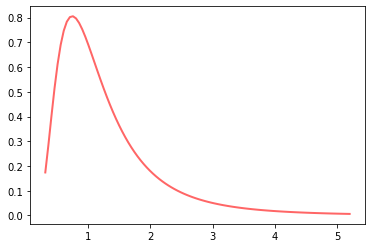

In [81]:
# example of F-distribution
import numpy as np
from scipy.stats import f
import matplotlib.pyplot as plt

# degrees of freedom
dfn, dfd = 30, 8

# 100 x points between the first and 99th percentile of the f-distribution & corresponding f values
x = np.linspace(f.ppf(0.01, dfn, dfd), f.ppf(0.99, dfn, dfd), 100)
y = f.pdf(x, dfn, dfd)

# plot
fig, ax = plt.subplots(1, 1)
ax.plot(x, f.pdf(x, dfn, dfd), 'r-', lw=2, alpha=0.6, label='f pdf')
plt.show()

### F-value

ANOVA compares two types of variance:

+ between groups: how far group means stray from the total mean
+ within groups: how far individual values stray from their respective group mean

The **F-value** is the variance between groups divided by the variance within groups, where:

+ the variance between groups equals the sum of squares group divided by the degrees of freedom (groups)
+ the variance within groups equals the sum of squares errors divided by the degrees of freedom (error)

The groups belong to the **same population** if the **variance between groups** (numerator) is **small** compared to the **variance within groups** (denominator).

### One-way ANOVA

In [72]:
# example: number of days each customer took to pay an invoice based on a percentage of discount if early payment
disc_0p = [14, 11, 18, 16, 21]
disc_1p = [21, 15, 23, 10, 16]
disc_2p = [11, 16,  9, 14, 10]

stats.f_oneway(disc_0p, disc_1p, disc_2p) # p-value > 0.05, the discounts make no significant difference

F_onewayResult(statistic=2.121212121212121, pvalue=0.16262315311926887)

### Two-way ANOVA

The **two-way ANOVA** is an extension of the one-way ANOVA to test **two independant variables** at the same time, taking interactions between these variables into account. 

_Note: this can be further generalized to N-way ANOVA._

In [109]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels as sm

# data - same as before, but checking if the amount has an impact
df = pd.DataFrame({
    'discount': ['2p','2p','2p','2p','2p','1p','1p','1p','1p','1p','0p','0p','0p','0p','0p'],
    'amount': [50,100,150,200,250,50,100,150,200,250,50,100,150,200,250],
    'days': [16,14,11,10,9,23,21,16,15,10,21,16,18,14,11]
})


# fit without interaction factor
model = ols('days ~ C(discount) + C(amount)', df).fit()

# discount has now become significant
sm.api.stats.anova_lm(model, typ=2)

# model.summary()

,sum_sq,df,F,PR(>F)
C(discount),70.0,2.0,11.666667,0.004249
C(amount),174.0,4.0,14.500000,0.000975
Residual,24.0,8.0,NaN,NaN


Note on `model.summary()`:
+ Durban-Watson detects the presence of autocorrelation
+ Jarque-Bera tests the assumption of normality
+ Omnibus tests the assumption of homogeneity of variance
+ Condition Number assess multicollinearity (should be < 20)

In [112]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels as sm

# data - three fertilizers, warm vs cold, size of plant
df = pd.DataFrame({
    'fertilizer': ['A','A','A','A','A','A','B','B','B','B','B','B','C','C','C','C','C','C'],
    'temperature': ['W','W','W','C','C','C','W','W','W','C','C','C','W','W','W','C','C','C'],
    'size': [13,14,12,16,18,17,21,19,17,14,11,14,18,15,15,15,13,8]
})


# fit with interaction factor
model = ols('size ~ C(fertilizer) * C(temperature)', df).fit()

# discount has now become significant
sm.api.stats.anova_lm(model, typ=2)

# model.summary()

,sum_sq,df,F,PR(>F)
C(fertilizer),12.0,2.0,1.44,0.275087
C(temperature),18.0,1.0,4.32,0.059786
C(fertilizer):C(temperature),84.0,2.0,10.08,0.002699
Residual,50.0,12.0,NaN,NaN


___

## Chi-Square Analysis 

The [Chi-Square Analysis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) determines the **probability of an observed frequency of events** given an expected frequency. If we get heads ten times in a row, how likely is it to happen if we assume the coin to be fair?

$\chi^2 = \sum (O - E)^2 / E$ for each possible outcome of an experiment

_Note: the expected value is not a probability._

### Chi-Square Distribution

The Chi-Square Distribution depends on its degrees of freedom, which are the number of possible outcomes minus one.

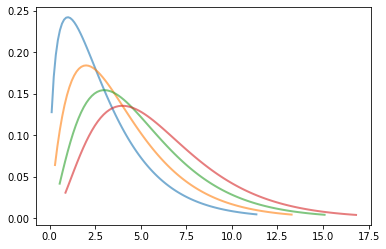

In [132]:
# example of Chi-Square-distribution
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

# plot
fig, ax = plt.subplots(1, 1)

# degrees of freedom
for df in [3,4,5,6]:

    # 100 x points between the first and 99th percentile of the f-distribution & corresponding f values
    x = np.linspace(chi2.ppf(0.01, df), chi2.ppf(0.99, df), 100)
    y = chi2.pdf(x, df)

    ax.plot(x, y, lw=2, alpha=0.6)

plt.show()

### One-way Chi-Square

We get 12 heads out of 18 coin tosses. Is the coin fair?

In [138]:
# example: we get 12 heads out of 18 coin tosses. Is the coin fair?
from scipy.stats import chisquare
chisquare([6, 12], f_exp=[9,9]) # p-value is > 5%: we fail to reject the null hypothesis

Power_divergenceResult(statistic=2.0, pvalue=0.15729920705028105)

Our company has six server that should fail at the same rate. Is it true?

In the example below, we have 240 failures. If the null hypothesis is true, the probability of failure should be the same for all the six servers: 1/6 or 40 failures per server. Let's test this: 

In [149]:
import numpy as np
from scipy.stats import chisquare

obs_failures = [46,36,52,26,42,38]
mean_failure = np.mean(obs_failures)

chisquare(obs_failures, f_exp=mean_failure) # p-value is > 5%: we fail to reject the null hypothesis

Power_divergenceResult(statistic=10.0, pvalue=0.07523524614651217)

Are most customers of a website teenagers?

In the example below, we have a sample of 400 visitors, 58% of which are teenagers. If the null hypothesis is true, the probability of having teenagers is 50% or less.

In [148]:
import numpy as np
from scipy.stats import chisquare

obs_values = [232, 400 - 232]
exp_values = [200, 200]

chisquare(obs_values, f_exp=exp_values) # p-value is < 5%: we reject the null hypothesis

Power_divergenceResult(statistic=10.24, pvalue=0.0013742758758316976)

###  Two-way Chi-Square

Suppose there is a city of 1,000,000 residents with four neighborhoods: $A$, $B$, $C$, and $D$. A random sample of 650 residents of the city is taken and their occupation is recorded as "white collar", "blue collar", or "no collar". 

|                | $A$   | $B$   | $C$   | $D$   | **Total** |
|----------------|-------|-------|-------|-------|-----------|
|White Collar    |  90   |  60   | 104   |  95   |  **349**  |
|Blue Collar     |  30   |  50   |  51   |  20   |  **151**  |
|No Collar       |  30   |  40   |  45   |  35   |  **150**  |
|**Total**       |**150**|**150**|**200**|**150**|  **650**  |


The null hypothesis is that each person's neighborhood of residence is independent of the person's occupational classification. By the assumption of independence under the hypothesis we should "expect" the number of white-collar workers in neighborhood $A$ to be:

$WC_A = 150\times\frac{349}{650} \approx 80.54$

So the contribution of this cell to $\chi^2$ is $\frac{(90 - 80.54)^2}{80.54} \approx 1.11$

The sum of these quantities over all of the cells is the test statistic; in this case, $\approx 24.6$.  Under the null hypothesis, this sum has approximately a chi-squared distribution whose number of degrees of freedom are:

$(\text{number of rows}-1)(\text{number of columns}-1) = (3-1)(4-1) = 6$

If the test statistic is improbably large according to that chi-squared distribution, then one rejects the null hypothesis of 'independence'. In this example, the neighborhood and occupation are linked.

In [145]:
import pandas as pd
import scipy.stats as stats

df = pd.DataFrame({
    'A': [ 90,30,30], 
    'B': [ 60,50,40], 
    'C': [104,51,45], 
    'D': [ 95,20,35]}, index=['White Collar', 'Blue Collar', 'No Collar']
)

display(df)

chi2, p, _, _ = stats.chi2_contingency(df)
print('Chi-Square test: {:.3} - p-value: {:.3}'.format(chi2, p)) # we reject the null hypothesis of independence

,A,B,C,D
White Collar,90,60,104,95
Blue Collar,30,50,51,20
No Collar,30,40,45,35


Chi-Square test: 24.6 - p-value: 0.00041


Another example: is the proportion of kids taking swimming lessons depend on their ethnicity:
+ 247 Black kids. 36.8% take swimming lessons
+ 308 Hispanic kids. 38.9% take swimming lessons

The null hypothesis is that the proportion of kids taking swimming lessons does not depend on their ethnicity.

In [146]:
# contingency matrix
df = pd.DataFrame({'black': [91, 156], 'hisp': [120, 188]}, index=['Swim', 'No Swim'])
display(df)

chi2, p, _, _ = stats.chi2_contingency(df)
print('Chi-Square test: {:.3} - p-value: {:.3}'.format(chi2, p)) # we fail to reject the null hypothesis of independence

,black,hisp
Swim,91,120
No Swim,156,188


Chi-Square test: 0.179 - p-value: 0.672
